In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Définir les répertoires pour les données d'entraînement et de validation
train_dir = 'path_to_train_directory'
val_dir = 'path_to_validation_directory'

# Préparation des données avec augmentation pour l'entraînement
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input  # Prétraitement spécifique à ResNet50
)

datagen_val = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_dataset = datagen_train.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='sparse'
)

val_dataset = datagen_val.flow_from_directory(
    val_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='sparse'
)

# Charger le modèle ResNet50 pré-entraîné sans la couche de classification
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congeler les premières couches du modèle pour éviter qu'elles soient entraînées
base_model.trainable = False

# Ajouter des couches supplémentaires pour la classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes de personnes
])

# Compiler le modèle avec un taux d'apprentissage faible
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Ajouter un callback pour arrêter l'entraînement en cas de sur-apprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Fine-tuning : Déverrouiller certaines couches de base_model pour les fine-tuner
base_model.trainable = True

# Déverrouiller les dernières couches de base_model (par exemple, les 100 dernières)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompiler le modèle avec un taux d'apprentissage encore plus faible pour le fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Reprendre l'entraînement en fine-tuning
history_fine_tune = model.fit(
    train_dataset, 
    epochs=5, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Évaluer sur un ensemble de test (si disponible)
test_dir = 'path_to_test_directory'
test_dataset = datagen_val.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='sparse'
)

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


In [2]:
# 1️⃣ Paramètres globaux
img_width, img_height = 224, 224  # Taille des images
batch_size = 32  # Taille des lots
epochs = 20  # Nombre d'epochs d'entraînement

In [3]:
# 2️⃣ Chemins vers les datasets
train_dir = 'dataset/train'  # Chemin vers les images d'entraînement
val_dir = 'dataset/test'  # Chemin vers les images de validation

In [4]:
# 3️⃣ Préparation des données (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [5]:
# 4️⃣ Chargement des images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important pour la matrice de confusion
)

Found 3264 images belonging to 4 classes.
Found 816 images belonging to 4 classes.


In [6]:
# 5️⃣ Chargement de l'architecture VGG16 pré-entraînée sur ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [7]:
# 6️⃣ Ajout de nos propres couches de classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

In [8]:
# 7️⃣ Création du modèle final
model = Model(inputs=base_model.input, outputs=output)


In [9]:
# 8️⃣ Geler les couches de VGG16 pour ne pas les réentraîner
for layer in base_model.layers:
    layer.trainable = False

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 📂 Chemin de sauvegarde du meilleur modèle
checkpoint_path = 'C:/Users/Minfo/face_recognition_flask/static/modele.keras'

# ⚙️ Callback pour sauvegarder le meilleur modèle automatiquement
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss',  # Critère à surveiller (par exemple, val_loss ou val_accuracy)
    save_best_only=True,  # Sauvegarder uniquement le meilleur modèle
    verbose=1  # Affiche des messages pendant l'entraînement
)

# ✅ 1️⃣ Compilation du modèle (manquant dans votre code)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Ou 'sparse_categorical_crossentropy' selon vos classes
    metrics=['accuracy']
)

# 🔥 2️⃣ Entraînement avec la sauvegarde automatique
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint]  # 👈 On ajoute le callback ici
)


C:\Users\Minfo\Downloads\datascience\kernil-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7488 - loss: 0.7153
Epoch 1: val_loss improved from inf to 0.01494, saving model to C:/Users/Minfo/face_recognition_flask/static/modele.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 627s 6s/step - accuracy: 0.7504 - loss: 0.7115 - val_accuracy: 1.0000 - val_loss: 0.0149
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9945 - loss: 0.0374
Epoch 2: val_loss did not improve from 0.01494
102/102 ━━━━━━━━━━━━━━━━━━━━ 628s 6s/step - accuracy: 0.9946 - loss: 0.0374 - val_accuracy: 0.9926 - val_loss: 0.0219
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9996 - loss: 0.0132
Epoch 3: val_loss improved from 0.01494 to 0.01334, saving model to C:/Users/Minfo/face_recognition_flask/static/modele.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 628s 6s/step - accuracy: 0.9996 - loss: 0.0132 - val_accuracy: 0.9939 - val_loss: 0.0133
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9994 - loss: 0.0091
Epoch 4: va

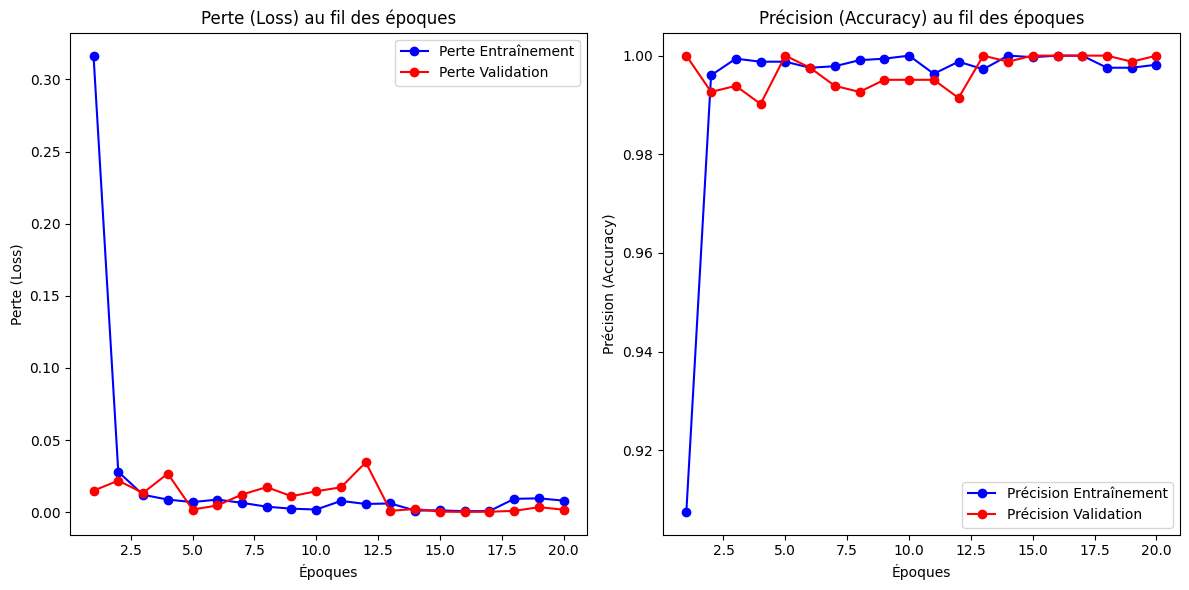

In [14]:
import matplotlib.pyplot as plt

# 🔍 Extraire l'historique de l'entraînement
history_dict = history.history

# 🔥 Récupérer la perte (loss) et la précision (accuracy) pour l'entraînement et la validation
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# 📅 Définir le nombre d'époques
epochs_range = range(1, len(loss) + 1)  # Les époques commencent à 1

# 📊 1️⃣ Affichage du diagramme de la **perte (loss)**
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Perte Entraînement')  # 'bo-' = points bleus connectés par des lignes
plt.plot(epochs_range, val_loss, 'ro-', label='Perte Validation')  # 'ro-' = points rouges connectés par des lignes
plt.title('Perte (Loss) au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()

# 📊 2️⃣ Affichage du diagramme de la **précision (accuracy)**
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, 'bo-', label='Précision Entraînement')  # 'bo-' = points bleus connectés par des lignes
plt.plot(epochs_range, val_accuracy, 'ro-', label='Précision Validation')  # 'ro-' = points rouges connectés par des lignes
plt.title('Précision (Accuracy) au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Précision (Accuracy)')
plt.legend()

# Afficher les deux graphiques
plt.tight_layout()  # Améliorer la disposition
plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step


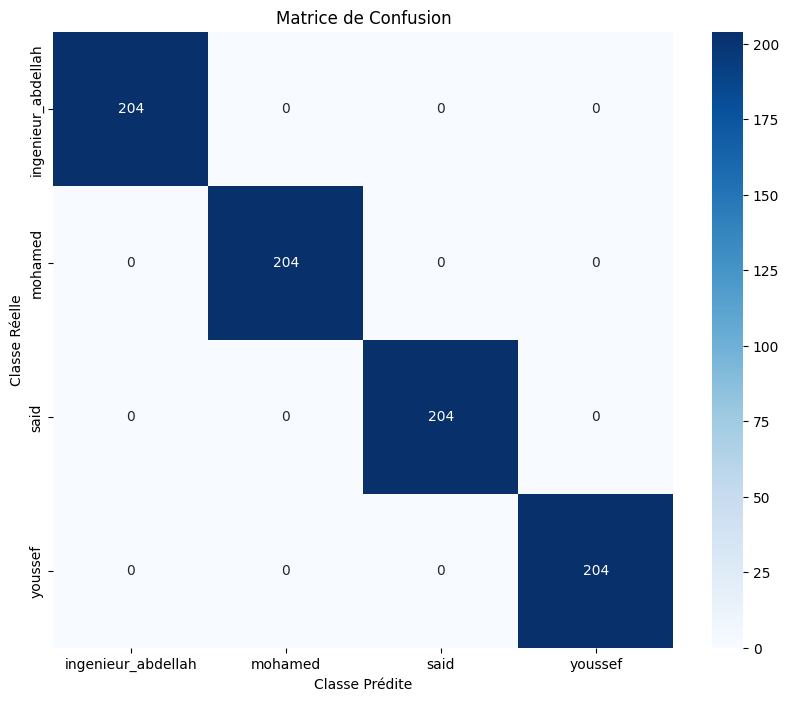

In [12]:
# 1️⃣1️⃣ Génération de la matrice de confusion
# Prédictions du modèle sur les images de validation
val_generator.reset()  # Réinitialiser le générateur
predictions = model.predict(val_generator, verbose=1)

# Obtenir les classes prédites et vraies
predicted_classes = np.argmax(predictions, axis=1)  # Prédictions
true_classes = val_generator.classes  # Classes réelles
class_labels = list(val_generator.class_indices.keys())  # Noms des classes

# Générer la matrice de confusion
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()

In [13]:
# 1️⃣2️⃣ Rapport de classification
print("\nRapport de Classification :\n")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Rapport de Classification :

                    precision    recall  f1-score   support

ingenieur_abdellah       1.00      1.00      1.00       204
           mohamed       1.00      1.00      1.00       204
              said       1.00      1.00      1.00       204
           youssef       1.00      1.00      1.00       204

          accuracy                           1.00       816
         macro avg       1.00      1.00      1.00       816
      weighted avg       1.00      1.00      1.00       816

